28834


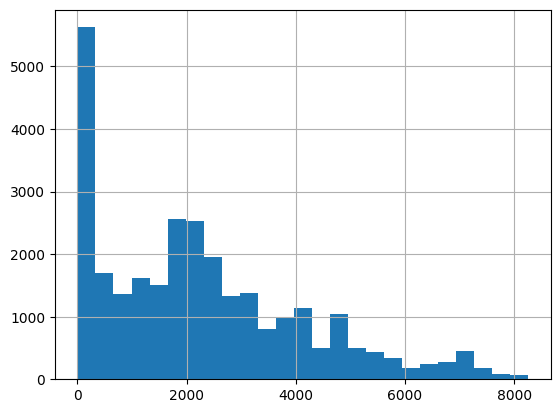

In [1]:
import pandas as pd
import datetime
import numpy as np

CSV_ROWS = [
    "Photo_Name",
    "Id",
    "Sex",
    "dob",
    "dob_estimated",
    "error_dob",
    "FaceView",
    "FaceQual",
    "Shootdate"
]

def csvdate_to_date(shoot_date):
    year, month, day = shoot_date.split("-")
    return datetime.date(int(year), int(month), int(day))    

def compute_age(row):
    photo_date = csvdate_to_date(row["Shootdate"])
    dob_date = csvdate_to_date(row["dob"])
    age = photo_date - dob_date
    return age.days

def add(row):
   return row[0]+row[1]+row[2]

data = pd.read_csv("MFD_metadatas.csv", dtype={'Shootdate': str})
data['Shootdate'].replace('nan', np.nan, inplace=True)
data = data.dropna()
data['age'] = data.apply(compute_age, axis=1)

def filter_by_age(data, age_in_days):
    return data[data['age'] <= age_in_days]

def filter_by_certainty(data):
    return data[data['dob_estimated'] == False]

def filter_dob_errors(data):
    return data[data["age"] >= 0]

# data["age"].hist(bins=25)

# data = filter_by_certainty(data)
data = filter_dob_errors(data)
data.reset_index(inplace=True, drop=True)

# data["age"].hist(bins=25)
print(len(data))

max_age = 25
max_days = 365 * max_age

one_year_data = filter_by_age(data, age_in_days=max_days)
one_year_data.reset_index(drop=True, inplace=True)

hist = one_year_data["age"].hist(bins=25)




In [2]:
def filter_by_qty(df, bins):
    value_range = pd.cut(df['age'], bins)

    print(value_range)
    # Count the occurrences of each value range
    range_counts = value_range.value_counts()

    # Find the minimum count among the value ranges
    min_count = range_counts.min()
    print(range_counts)

    # Filter the DataFrame to have the same number of occurrences for each value range
    filtered_df = df.groupby(value_range).apply(lambda x: x.sample(200, replace=True))

    # Reset the index of the filtered DataFrame
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df

#one_year_data = filter_by_qty(one_year_data, bins=50)
#one_year_data.reset_index(inplace=True, drop=True)
#one_year_data["age"].hist(bins=25)
#len(one_year_data)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
import cv2
import os
from tqdm import tqdm
import random

# Define your custom dataset
class MandrillImageDataset(Dataset):
    def __init__(self, root_dir, dataframe, img_size=(224, 224), device="cuda", in_mem=True):
        self.df = dataframe
        self.root_dir = root_dir
        self.img_size = img_size
        self.in_mem = in_mem
        if self.in_mem:
            self.images = []
            for i in tqdm(range(len(self.df))):
                row = self.df.iloc[[i]]
                self.images.append(self.load_photo(row))

    def load_photo(self, row):
        image_path = self.photo_path(row)
        image = cv2.imread(image_path)
        if image.shape[0:2] != self.img_size:
            image = cv2.resize(image, self.img_size, interpolation = cv2.INTER_AREA)
        image = np.moveaxis(image, -1, 0) # Channel first format
        image = image.astype(np.float32) / 255.0
        return image
            
    def photo_path(self, row):
        return os.path.join(self.root_dir, f"{row['Id'].values[0]}", f"{row['Photo_Name'].values[0]}")
        
    def __len__(self):
        return len(self.df)
    
    def _getpair(self, idx):
        row = self.df.iloc[[idx]]

        target = float(row["age"].values[0])
        target = target / max_days

        if self.in_mem:
            image = self.images[idx]
        else:
            image = self.load_photo(row)
        return torch.tensor(image).to(device), torch.tensor(target).to(device)
    
    def set_images(self, images):
        self.images = images
        self.in_mem = True
    
    def __getitem__(self, idx):
        return self._getpair(idx)

class MandrillDualImageDataset(MandrillImageDataset):
    def __init__(self, root_dir, dataframe, img_size=(224, 224), device="cuda", images=None, in_mem=False):
        super(MandrillDualImageDataset, self).__init__(root_dir, dataframe, img_size, device, in_mem)
        if images is not None:
            self.images = images
            self.in_mem = True
                    
    def get_same_mandrill_idx(self, mandrill_id):
        ids = self.df[self.df.Id == mandrill_id].index
        return ids
    
    def __getitem__(self, idx):
        # Randomize
        idx = random.randint(0, len(self)-1)
        #row = self.df.iloc[[idx]]
        #mandrill_id = row["Id"].values[0]
        #ids = self.get_same_mandrill_idx(mandrill_id)
        #second_idx = random.choice(ids)
        
        second_idx = random.randint(0, len(self)-1)
        x1, y1 = self._getpair(idx)
        x2, y2 = self._getpair(second_idx)

        # y1 = y1.cpu().numpy()
        # y2 = y2.cpu().numpy()
        sign = torch.sign(y1 - y2)
        y = torch.zeros([3], device=device)
        y[int(sign) + 1] = 1
        return [x1, x2], y

class MandrillTripleImageDataset(MandrillImageDataset):
    def __init__(self, root_dir, dataframe, img_size=(224, 224), device="cuda", images=None, in_mem=False):
        super(MandrillTripleImageDataset, self).__init__(root_dir, dataframe, img_size, device, in_mem)
        if images is not None:
            self.images = images
            self.in_mem = True
    
    def __getitem__(self, idx):
        # Get three random idx
        second_idx = random.randint(0, len(self)-1)
        third_idx = random.randint(0, len(self)-1)
        x1, y1 = self._getpair(idx)
        x2, y2 = self._getpair(idx2)
        x3, y3 = self._getpair(idx3)
        
        y2y1 = abs(y1 - y2)
        y3y1 = abs(y1 - y3)
        
        if y2y1 > y3y1:
            triplet = ((x1, x3, x2), (y1, y3, y2))
        else:
            triplet = ((x1, x2, x3), (y1, y2, y3))
        x, y = triplet
        return x, y
    
# Define your model
from collections import OrderedDict
def build_layers(n, method, prev_features, current_features, down=True):
    layers = OrderedDict()
    for i in range(n):
        layers[str(i)] = method(prev_features, current_features)
        prev_features = current_features
        if down:
            current_features = current_features // 2
        else:
            current_features = current_features * 2
    return layers, prev_features

    
class BackboneRegressionModel(nn.Module):
    def __init__(self, im_size=224, n_channels=3, conv_start=64, n_convs=5):
        super(BackboneRegressionModel, self).__init__()
        previous_feature_size = n_channels
        current_feature_size = conv_start
        convs_layers, last_feature_size = build_layers(
            n_convs, self.conv_block, previous_feature_size, current_feature_size, down=False
        )
        self.conv_blocks = nn.Sequential(convs_layers)
        
        last_scale = (2 ** (n_convs))
        last_size = im_size // last_scale
        self.last_layer_size = last_feature_size * last_size * last_size

    def conv_block(self, in_features, out_features):
        conv = nn.Conv2d(in_features, out_features, 3, padding="same")
        relu = nn.ReLU(inplace=True)
        bn = nn.BatchNorm2d(out_features)
        pool = nn.MaxPool2d((2,2))
        return nn.Sequential(conv, relu, bn, pool)
    
    def forward(self, x):
        return self.conv_blocks(x)

class RegressionModel(nn.Module):
    def __init__(self, cnn_backbone, lin_start=2048, n_lin=6):
        super(RegressionModel, self).__init__()
        self.cnn_backbone = cnn_backbone

        ############ Dense layers ########
        previous_feature_size = self.cnn_backbone.last_layer_size
        current_feature_size = lin_start
        lin_layers, last_feature_size = build_layers(
            n_lin, self.block, previous_feature_size, current_feature_size
        )
        self.blocks = nn.Sequential(lin_layers)
        self.age = nn.Linear(last_feature_size, 1)

    def block(self, in_features, out_features):
        lin = nn.Linear(in_features, out_features)
        relu = nn.ReLU(inplace=True)
        return nn.Sequential(lin, relu)

    def __del__(self):
        del self.conv_blocks
        del self.blocks
        del self.x_coords
        del self.y_coords

    def forward(self, x):
        z = self.cnn_backbone(x)
        z = torch.reshape(z, (z.shape[0], z.shape[1] * z.shape[2] * z.shape[3]))
        z = self.blocks(z)
        z = self.age(z)
        z = torch.reshape(z, (z.shape[0],))
        return z

class DualRegressionModel(nn.Module):
    def __init__(self, cnn_backbone, lin_start=2048, n_lin=6):
        super(DualRegressionModel, self).__init__()
        self.cnn_backbone = cnn_backbone
        
        previous_feature_size = 2* self.cnn_backbone.last_layer_size
        current_feature_size = lin_start
        lin_layers, last_feature_size = build_layers(
            n_lin, self.block, previous_feature_size, current_feature_size
        )
        self.blocks = nn.Sequential(lin_layers)
        self.age_gap = nn.Linear(last_feature_size, 3)
        # self.activation = nn.Softmax()
    
    def block(self, in_features, out_features):
        lin = nn.Linear(in_features, out_features)
        relu = nn.ReLU(inplace=True)
        return nn.Sequential(lin, relu)
    
    def get_z(self, x):
        z = self.cnn_backbone(x)
        z = torch.reshape(z, (z.shape[0], z.shape[1] * z.shape[2] * z.shape[3]))
        return z

    def forward(self, x):
        x1, x2 = x
        z1 = self.get_z(x1)
        z2 = self.get_z(x2)
        z = torch.cat([z1, z2], axis=-1)
        z = self.blocks(z)
        z = self.age_gap(z)
        # z = torch.reshape(z, (z.shape[0],))
        # z = self.activation(z)
        return z

class TripletRegressionModel(nn.Module):
    def __init__(self, cnn_backbone, lin_start=2048, n_lin=6):
        super(TripletRegressionModel, self).__init__()
        self.cnn_backbone = cnn_backbone
        previous_feature_size = 3* self.cnn_backbone.last_layer_size
        current_feature_size = lin_start
        lin_layers, last_feature_size = build_layers(
            n_lin, self.block, previous_feature_size, current_feature_size
        )
        self.blocks = nn.Sequential(lin_layers)
        self.age_gap = nn.Linear(last_feature_size, 3)
    
learning_rate = 0.001
dual_learning_rate = 0.001
batch_size = 64
num_epochs = 500
train_ratio = 0.8

# Dataset and DataLoader
dataset = MandrillImageDataset(root_dir='Images', dataframe=one_year_data, in_mem=True)
dual_dataset = MandrillDualImageDataset(root_dir='Images', dataframe=one_year_data, in_mem=False)
dual_dataset.set_images(dataset.images)
triplet_dataset = MandrilTripleImageDataset(root_dir='Images', dataframe=one_year_data, in_mem=False)
triplet_dataset.set_images(dataset.images)


def split_dataset(dataset, train_ratio, batch_size):
    # Split the dataset into training and validation subsets
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, train_dataset, val_dataset

train_loader, val_loader, train_dataset, val_dataset = split_dataset(dataset, train_ratio, batch_size)
dual_train_loader, dual_val_loader, _, _ = split_dataset(dual_dataset, train_ratio, batch_size)
triplet_train_loader, triplet_val_loader, _, _ = split_dataset(triplet_dataset, train_ratio, batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Model
backbone = BackboneRegressionModel()
backbone = backbone.to(device)
model = RegressionModel(backbone)
dual_model = DualRegressionModel(backbone)
triplet_model = TripletRegressionModel(backbone)

# Loss function
mse = nn.MSELoss()

class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()
        self.epsilon = 1e-6

    def forward(self, prediction, true_value):
        log_pred = torch.log(abs(prediction) * self.epsilon) * max_days
        log_true = torch.log(abs(true_value) + self.epsilon) * max_days
        log_diff = log_true - log_pred # Compute logarithmic difference
        weighted_mse = torch.mean(abs(log_diff) * torch.pow(prediction - true_value, 2))  # Weighted MSE
        return weighted_mse

criterion = WeightedMSELoss()
dual_criterion = nn.CrossEntropyLoss()
val_criterion = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
dual_optimizer = optim.Adam(model.parameters(), lr=dual_learning_rate)


model = model.to(device)
dual_model = dual_model.to(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    
def train_step(loader, index, optimizer, model, criterion):
    images, labels = next(iter(loader))
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    size = 0
    if isinstance(images, list):
        size = images[0].size(0)
    else:
        size = images.size(0)

    return loss.item() * size
    
def save(backbone, model, dual_model, prefix):
    torch.save(backbone.state_dict(), f"models/{prefix}_exp4_backbone.h5")
    torch.save(model.state_dict(), f"models/{prefix}_exp4_model.h5")
    torch.save(dual_model.state_dict(), f"models/{prefix}exp4_dual_model.h5")
    
def load(backbone, model, dual_model, prefix):
    backbone.load_state_dict(torch.load(f"models/{prefix}_exp4_backbone.h5"))
    model.load_state_dict(torch.load(f"models/{prefix}_exp4_model.h5"))
    dual_model.load_state_dict(torch.load(f"models/{prefix}exp4_dual_model.h5"))
    return backbone, model, dual_model

#######
train = True
#######
    
if train:

    # Training loop
    best_val = np.inf
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        dual_train_loss = 0.0
        steps = len(train_loader)

        for i in tqdm(range(steps)):
            train_loss += train_step(train_loader, i, optimizer, model, criterion)
            dual_train_loss += train_step(dual_train_loader, i, dual_optimizer, dual_model, dual_criterion)

        train_loss /= len(train_dataset)
        dual_train_loss /= len(train_dataset)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                outputs = model(images)
                loss = val_criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_dataset)

        if val_loss < best_val:
            print(f"Val loss improved from {best_val:.4f} to {val_loss:.4f}")
            best_val = val_loss
            save(backbone, model, dual_model, "best")
        else:
            print(f"Val loss did not improved from {best_val:.4f}")

        # Print training and validation metrics
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.5f} - "
              f"Train Dual loss: {dual_train_loss:.5f} - "
              f"Val L1: {val_loss:.5f}")

    torch.save(backbone.state_dict(), "models/exp4_backbone.h5")
    torch.save(model.state_dict(), "models/exp4_model.h5")
    torch.save(dual_model.state_dict(), "models/exp4_dual_model.h5")

100%|██████████| 28834/28834 [02:34<00:00, 186.94it/s]


Using device: cuda

Tesla T4
Memory Usage:
Allocated: 1.2 GB
Cached:    1.2 GB


100%|██████████| 91/91 [00:13<00:00,  6.72it/s]


Val loss improved from inf to 0.0574
Epoch [1/500] - Train Loss: 5271.17126 - Train Dual loss: 0.92870 - Val L1: 0.05737


100%|██████████| 91/91 [00:13<00:00,  6.72it/s]


Val loss improved from 0.0574 to 0.0467
Epoch [2/500] - Train Loss: 897.79204 - Train Dual loss: 0.79702 - Val L1: 0.04668


100%|██████████| 91/91 [00:14<00:00,  6.43it/s]


Val loss did not improved from 0.0467
Epoch [3/500] - Train Loss: 660.68921 - Train Dual loss: 0.71530 - Val L1: 0.05909


100%|██████████| 91/91 [00:13<00:00,  6.50it/s]


Val loss improved from 0.0467 to 0.0375
Epoch [4/500] - Train Loss: 574.29105 - Train Dual loss: 0.64912 - Val L1: 0.03750


100%|██████████| 91/91 [00:13<00:00,  6.78it/s]


Val loss did not improved from 0.0375
Epoch [5/500] - Train Loss: 499.13567 - Train Dual loss: 0.59650 - Val L1: 0.03757


100%|██████████| 91/91 [00:13<00:00,  6.81it/s]


Val loss did not improved from 0.0375
Epoch [6/500] - Train Loss: 398.63484 - Train Dual loss: 0.55165 - Val L1: 0.03795


100%|██████████| 91/91 [00:13<00:00,  6.74it/s]


Val loss improved from 0.0375 to 0.0359
Epoch [7/500] - Train Loss: 381.02773 - Train Dual loss: 0.51078 - Val L1: 0.03590


100%|██████████| 91/91 [00:13<00:00,  6.84it/s]


Val loss improved from 0.0359 to 0.0311
Epoch [8/500] - Train Loss: 301.49039 - Train Dual loss: 0.47384 - Val L1: 0.03114


100%|██████████| 91/91 [00:13<00:00,  6.75it/s]


Val loss did not improved from 0.0311
Epoch [9/500] - Train Loss: 299.11232 - Train Dual loss: 0.44382 - Val L1: 0.03228


100%|██████████| 91/91 [00:13<00:00,  6.65it/s]


Val loss did not improved from 0.0311
Epoch [10/500] - Train Loss: 268.57775 - Train Dual loss: 0.41697 - Val L1: 0.03406


100%|██████████| 91/91 [00:13<00:00,  6.63it/s]


Val loss did not improved from 0.0311
Epoch [11/500] - Train Loss: 262.86569 - Train Dual loss: 0.39049 - Val L1: 0.03408


100%|██████████| 91/91 [00:13<00:00,  6.72it/s]


Val loss did not improved from 0.0311
Epoch [12/500] - Train Loss: 227.07734 - Train Dual loss: 0.36537 - Val L1: 0.03514


100%|██████████| 91/91 [00:13<00:00,  6.73it/s]


Val loss did not improved from 0.0311
Epoch [13/500] - Train Loss: 206.76359 - Train Dual loss: 0.34627 - Val L1: 0.03354


100%|██████████| 91/91 [00:13<00:00,  6.91it/s]


Val loss improved from 0.0311 to 0.0304
Epoch [14/500] - Train Loss: 206.94924 - Train Dual loss: 0.32499 - Val L1: 0.03041


100%|██████████| 91/91 [00:13<00:00,  6.83it/s]


Val loss improved from 0.0304 to 0.0277
Epoch [15/500] - Train Loss: 164.17012 - Train Dual loss: 0.31304 - Val L1: 0.02771


100%|██████████| 91/91 [00:13<00:00,  6.92it/s]


Val loss did not improved from 0.0277
Epoch [16/500] - Train Loss: 166.51475 - Train Dual loss: 0.29346 - Val L1: 0.02797


100%|██████████| 91/91 [00:13<00:00,  6.66it/s]


Val loss improved from 0.0277 to 0.0263
Epoch [17/500] - Train Loss: 139.24956 - Train Dual loss: 0.28182 - Val L1: 0.02627


100%|██████████| 91/91 [00:13<00:00,  6.61it/s]


Val loss did not improved from 0.0263
Epoch [18/500] - Train Loss: 141.50537 - Train Dual loss: 0.26968 - Val L1: 0.02938


100%|██████████| 91/91 [00:13<00:00,  6.54it/s]


Val loss did not improved from 0.0263
Epoch [19/500] - Train Loss: 135.05692 - Train Dual loss: 0.25623 - Val L1: 0.03207


100%|██████████| 91/91 [00:13<00:00,  6.63it/s]


Val loss improved from 0.0263 to 0.0253
Epoch [20/500] - Train Loss: 127.64322 - Train Dual loss: 0.24629 - Val L1: 0.02528


100%|██████████| 91/91 [00:13<00:00,  6.84it/s]


Val loss did not improved from 0.0253
Epoch [21/500] - Train Loss: 113.91151 - Train Dual loss: 0.23374 - Val L1: 0.02633


100%|██████████| 91/91 [00:13<00:00,  6.86it/s]


Val loss improved from 0.0253 to 0.0252
Epoch [22/500] - Train Loss: 119.78758 - Train Dual loss: 0.22861 - Val L1: 0.02518


100%|██████████| 91/91 [00:13<00:00,  6.73it/s]


Val loss did not improved from 0.0252
Epoch [23/500] - Train Loss: 100.63225 - Train Dual loss: 0.21804 - Val L1: 0.02565


100%|██████████| 91/91 [00:13<00:00,  6.74it/s]


Val loss did not improved from 0.0252
Epoch [24/500] - Train Loss: 92.96303 - Train Dual loss: 0.20882 - Val L1: 0.02716


100%|██████████| 91/91 [00:13<00:00,  6.78it/s]


Val loss improved from 0.0252 to 0.0240
Epoch [25/500] - Train Loss: 107.92178 - Train Dual loss: 0.20010 - Val L1: 0.02396


100%|██████████| 91/91 [00:13<00:00,  6.83it/s]


Val loss improved from 0.0240 to 0.0226
Epoch [26/500] - Train Loss: 89.61135 - Train Dual loss: 0.19391 - Val L1: 0.02264


 31%|███       | 111/361 [02:10<04:55,  1.18s/it]

In [ ]:
import matplotlib.pyplot as plt

backbone, model, dual_model = load(backbone, model, dual_model, "best")

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

max_display = 10

age_errors = []
age_truth = []
age_predicted = []

# Perform inference on validation images
for i, (images, targets) in enumerate(val_loader):
    # Forward pass
    outputs = model(images)
    
    # Convert the outputs to numpy arrays
    predicted_values = outputs.squeeze().detach().cpu().numpy() * max_days
    actual_values = targets.squeeze().cpu().numpy() * max_days
    
    age_errors.append(predicted_values - actual_values)
    age_truth.append(actual_values)
    age_predicted.append(predicted_values)
    
    if i >= max_display:
        continue
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {predicted_values}, Actual: {actual_values}")
    plt.show()

    # Display the results
    print("Predicted Values:", predicted_values, " (years : ", predicted_values / 365, " )")
    print("Actual Values:", actual_values, " (years : ", actual_values / 365, " ) ")
    print("Prediction Error: ", (predicted_values - actual_values) / 365)
    print()  # Add an empty line for separation
    
    
age_errors = np.array(age_errors)
print("Age error (in days): ", np.mean(age_errors), " std: ", np.std(age_errors))

In [ ]:
# Histogram with x being the real age and y being the error on this age
# Plotting the histogram

def group_by(x, n_bins):
    step = np.max(x) / n_bins
    x = np.array(x)
    for i in range(n_bins+1):
        nx = i*step
        px = max(0, (i-1)*step)
        x[np.logical_and(x <= nx, x > px)] = nx
    x[np.logical_and(x <= np.max(x), x > (n_bins*step))] = np.max(x)
    return x.tolist()

def bin_errors(x, y):
    bins = np.unique(x)
    y_mean = []
    y_err = []
    y = np.array(y)
    for b in bins:
        y_bin = y[x == b]
        y_mean.append(np.mean(y_bin))
        y_err.append(np.std(y_bin))
    return np.array(y_mean), np.array(y_err)

n_bins = 25*2

x = age_truth
y = age_errors

sorted_lists = sorted(zip(x, y))
sorted_x, sorted_y = zip(*sorted_lists)

def display_error_curve(x, y, n_bins):
    x = group_by(x, n_bins)
    y, y_err = bin_errors(x, y)
    x = np.unique(x)

    plt.plot(x, y, 'k-', label='Prediction error')
    plt.fill_between(x, y-y_err, y+y_err)
    
    z = np.poly1d(np.polyfit(x, y, 2))
    plt.plot(x, z(x), color='red')
    
    plt.show()

display_error_curve(sorted_x, sorted_y, n_bins)
display_error_curve(sorted_x, abs(np.array(sorted_y)), n_bins)

# Distribution of image according to the age
hist = one_year_data["age"].hist(bins=n_bins)